In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import traceback
import random
import time

# 1.Deterministic environment

## Environment

In [2]:
class GridEnvironment(gym.Env):
    
    # Initializes the class
    def __init__(self):    
        self.observation_space = spaces.Discrete(16) #create observation-space
        self.action_space = spaces.Discrete(4) #create action-space
        self.time_step = 0 #create timestep-counter
        self.grid_size = 4 #create grid-size variable
        self.max_time_steps = 50 #set max possible transitions in an episode
        
    #takes 1 step forward in the env
    def step(self,action):
        
        next_state = self.get_next_state(action)  #get next-state for the current state,action pair
        reward = self.rewards[next_state] #get rewards for going the next-state
        self.rewards[next_state] = -1 #remove rewards and make it just an additional move 
        self.time_step += 1 #increase time-step
        done = True if self.time_step > self.max_time_steps else False #check if max time steps are exceeded
        info = {}
        return next_state, reward, done, info 
    
    #resets the env. 
    def reset(self):
        self.rewards = self.reset_rewards() #create/reset rewards for the env
        #self.state = 0 #set inital state to zero
        self.terminal_state = 15 #set terminal/goal state
        self.time_step = 1 #increase timestep
        pass
    
    #render current state
    def render(self):
        state = np.zeros((4,4))
        current_cell = self.state
        current_x,current_y = int(current_cell/4),int(current_cell%4)
        terminal_cell = self.terminal_state
        terminal_x,terminal_y = int(terminal_cell/4),int(terminal_cell%4)
        state[current_x,current_y] = 0.5
        state[terminal_x,terminal_y] = 1
        
        plot_env_current_state(state) #plot current state matrix of the env as an image
    
    #helper, resets rewards
    def reset_rewards(self):
        rewards = np.full((16),-1) 
        rewards[3] = 25
        rewards[10] = -10
        rewards[12] = -20
        rewards[13] = 10
        rewards[15] = 100
        return rewards
    
    #helper, gets next state given current state and action
    def get_next_state(self,action):
        x = int(self.state / self.grid_size)
        y = int(self.state % self.grid_size )

        if action == 0: #move left
            y -= 1
        elif action == 1: #move right
            y += 1
        elif action == 2: #move up
            x -= 1
        elif action == 3: #move down
            x += 1
        else:
            return -1
 
        x = np.clip(x,0,self.grid_size-1)
        y = np.clip(y,0,self.grid_size-1)
        next_state = (self.grid_size*x) + y
        
        return next_state
        

## Agent

In [3]:
class RandomAgent:
    #initialize the agent
    def __init__(self, env,epsilon,epsilon_decay_rate):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.terminal_state = env.terminal_state
        self.time_step = env.time_step 
        
        self.q_table = self.set_q_table() #Q-Table for the Agent(which is it's decision policy)
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate 
        
        self.action_type = -1 #tracker to track greedy and random actions
        
    #given current state,the agent takes a step to generate an action to perform
    def step(self, state):
        #generate action using epsilon greedy
        rand_num = np.random.random() 
        if self.epsilon > rand_num: # explore
            self.action_type = 0 #random
            return np.random.randint(self.action_space.n) 
        else: # exploit
            self.action_type = 1 #greedy
            return self.get_max_q_value_action(state) # gien a state, return action with maximum q-value
        return -1
        
    #resets the agent
    def reset(self):
        pass
    
    #initializes q-table(policy) for the agent to make decisions
    def set_q_table(self):
        q_table = np.full((self.observation_space.n , self.action_space.n),0) # states*actions
        for i in range(len(q_table[self.terminal_state])):
            q_table[self.terminal_state,i] = 0 #set all q-vals to 0
        return q_table
    
    #updates q-table after a transition
    def update_q_table(self,state,action,reward,next_state,next_action,learning_rate,discount_factor):
        #formula for Q-Learning
        FD = reward + discount_factor*(self.q_table[next_state,next_action])
        TD = learning_rate*(FD - self.q_table[state,action])
        self.q_table[state,action] += TD
        
    #get max q value action given a particluar state
    def get_max_q_value_action(self,state):
        
        q_values = self.q_table[state] #all action q-values for the state
        best_actions = np.argwhere(q_values == np.amax(q_values)) #get the best ones with max-value
        
        #if multiple best actions, choose a random one
        if best_actions.shape[0] > 1:
            return np.random.choice(best_actions[0])
        
        return best_actions[0][0]

### plot-helpers

In [4]:
def plot_env_current_state(state,env_type,algo_type):    
    plt.figure(figsize=(3,3))
    plt.imshow(state)
    plt.title("Grid-State" + " for "+env_type+" using "+algo_type)
    plt.ylabel("y-axis")
    plt.xlabel("x-axis")
    plt.show()

def plot_eps_decay(epsilon_vals,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(epsilon_vals)
    plt.title('Epsilon-decay'+ " for "+env_type+" using"+algo_type)
    plt.ylabel('Epsilon')
    plt.xlabel('Epsiode No')
    plt.show()
    
def plot_cum_rewards(total_reward_per_ep,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(total_reward_per_ep)
    plt.title('Total Reward Per Episode'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('Total Reward')
    plt.xlabel('Epsiode No')
    plt.show()
    
    
def plot_paths_travelled(total_path_travelled,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(total_path_travelled)
    plt.title('Total Path Travelled Per Episode' + " for "+env_type+" using "+algo_type)
    plt.ylabel('Steps made in Episode')
    plt.xlabel('Epsiode No')
    plt.show()
    
    
def plot_q_values_sum(q_values_sum,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(q_values_sum)
    plt.title('Q-Values SUM overtime'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('SUM of Q-Value')
    plt.xlabel('Epsiode No')
    plt.show()
    
def plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(random_actions_per_ep, label = "random_actions_per_ep")
    plt.plot(greedy_actions_per_ep, label = "greedy_actions_per_ep")
    plt.title('Random vs Greedy actions took per EP'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('Total Q-Value')
    plt.xlabel('Epsiode No')
    plt.legend(loc='best')
    plt.show()
    

## Main

In [26]:
env_type = "Deterministic Env"
algo_type = " SARSA"
def main(episodes=10,gamma=0.95,random_start_state=1,specific_start_state=0):
    
    #set parameters
    alpha = 0.15 #learning-rate
    #gamma = 0.9 #discount_factor
    
    epsilon = 1 #greedy/random factor
    epsilon_decay_rate = 0.001 #greedy/random factor decay rate

    #set tracking variables
    epsilon_vals = np.array([epsilon]) #do eps-decay
    total_path_travelled = np.array([]) #for no of tranisitions-made
    total_reward_per_ep = np.array([]) #for total rewards collected in an episode
    q_values_sum = np.array(-1) #to check the convergence of q-values
    random_actions_per_ep = np.array([]) #for no of random actions took per episode
    greedy_actions_per_ep = np.array([]) #for no of greedy actions took per episode
    total_actions_per_ep = np.array([]) #for no of overall actions took per episode(transitions made)
    state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)
    for i in range(state_rewards.shape[0]): #initialize the above variable
        state_rewards[i] = np.array([])
    
    #set environment and agent
    env = GridEnvironment()
    env.reset()
    agent = RandomAgent(env,epsilon,epsilon_decay_rate)
    agent.reset()
    
    #start training
    for ep in range(episodes):
        #now = time.time()
        #print("Episode No:",ep,"time taken till this ep:",np.round(now-program_starts,2),"s")
        
        env.reset() #reset env beore each episode
        agent.reset() #reset agent before each episode
        
        #check if we need a random start state or a specified start state for each epiode
        if random_start_state:
            #choose a random start state
            S = env.observation_space.sample()
            if S == env.terminal_state: # if inital state is final state, terminate the episode
                ep -= 1
                continue
        else:
            S = specific_start_state
        env.state = S #set env state to the chosen state
        
        #trackers for episodic data
        start_state = S #start state of the episode
        episode_path = np.array([]) #path of the episode
        episode_rewards = 0 #rewards collected in the episode
        greedy_count = 0 #greedy actions took in the episode
        random_count = 0 #random actions took in the episode
        total_count = 0 #all actions took in the episode(transitions)
                                         
        #till it's not a terminal state
        while S != env.terminal_state:  
            
            A = agent.step(S) #agent chooses an action
            NS , R, Done, Info = env.step(A) #env gives feedback for the action chosen through 
                                                                            #next available state,
                                                                            #reward recieved etc
            NA = agent.step(NS) #agent chooses next action based on next state
            agent.update_q_table(S,A,R,NS,NA,alpha,gamma) #agent updates it's Q-table(policy)
            
            episode_path = np.append(episode_path,S) #add to episode path
            episode_rewards += R #increase episode rewards
            
            #print(S,A,R,NS,episode_rewards)
            
            S = NS #change state to next state
            env.state = S #change environment's state
            
            #increase action counts accordingly
            if agent.action_type == 0: #random
                random_count += 1 
            if agent.action_type == 1: #greedy
                greedy_count += 1
            total_count += 1
            
            #if timesteps are maxed, terminate the episode
            if Done:
                break
                
            #env.render()
        
        #decay epsilon
        agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**ep) #exponential decay
        agent.epsilon = max(agent.epsilon,0.01) #keep epsilon to a min value so that 
                                                #agent can explore even in latter stages
        
        #update all tracking-variables
        epsilon_vals = np.append(epsilon_vals,agent.epsilon) #
        total_reward_per_ep = np.append(total_reward_per_ep,episode_rewards)
        total_path_travelled = np.append(total_path_travelled,len(episode_path))
        q_values_sum = np.append(q_values_sum,agent.q_table.sum())
        random_actions_per_ep = np.append(random_actions_per_ep,random_count)
        greedy_actions_per_ep = np.append(greedy_actions_per_ep,greedy_count)
        total_actions_per_ep = np.append(total_actions_per_ep,total_count)
        state_rewards[start_state] = np.append(state_rewards[start_state],episode_rewards)
    
    #env.render() 
    print("Q-Table\n",agent.q_table)
    #print(get_all_states_max_reward_path(agent.q_table))
    plot_eps_decay(epsilon_vals,env_type,algo_type) #plot epsiolon values over time
    plot_cum_rewards(total_reward_per_ep,env_type,algo_type) #plot total rewards for each episode
    plot_paths_travelled(total_path_travelled,env_type,algo_type) #plot total transitions for each episode
    plot_q_values_sum(q_values_sum,env_type,algo_type) #plot avg q-values for each episode
    #plot actions type for each episode
    plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type) 
    #print(total_actions_per_ep)
    print("Starting-state,Total-Reward in an episode for all episodes ")
    for i in range(state_rewards.shape[0]): # for each state as an inital state
        print(i,list(state_rewards[i])) #print it's total episodic rewards
        

Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  8  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0 -2]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0 -2  0  0]
 [ 0  0  0  0]
 [-1  0  0 37]
 [ 0  0  0  0]
 [-3  0  0  0]
 [ 0 15  0  1]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2775499293.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


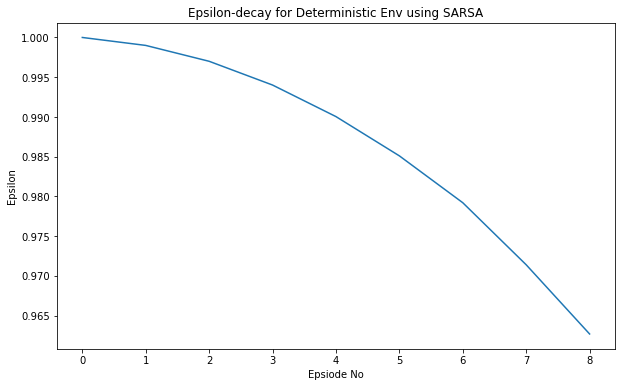

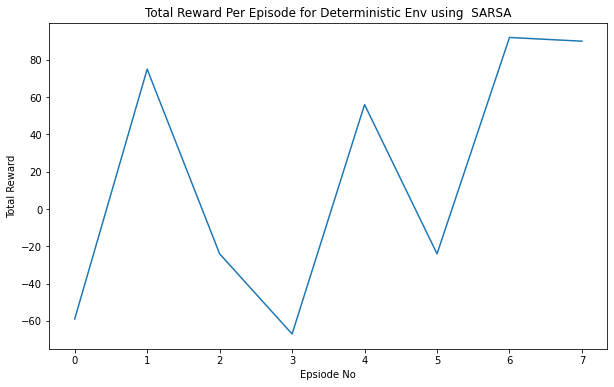

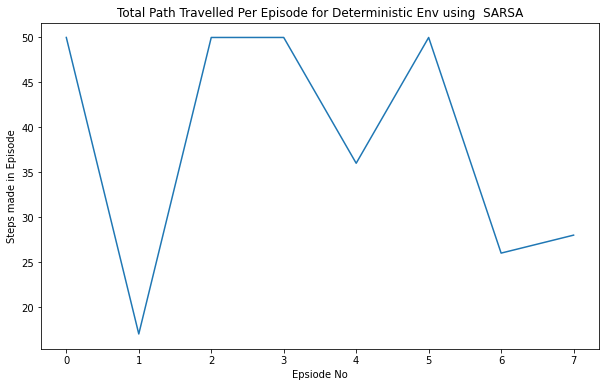

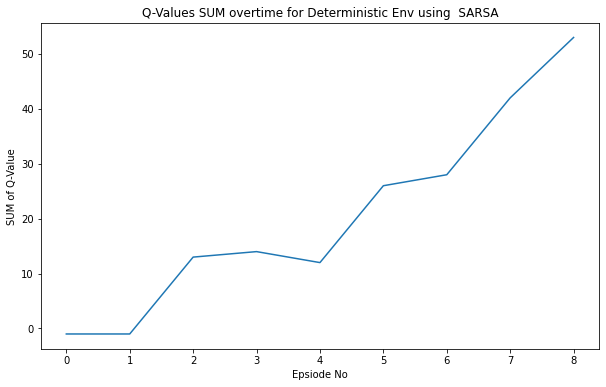

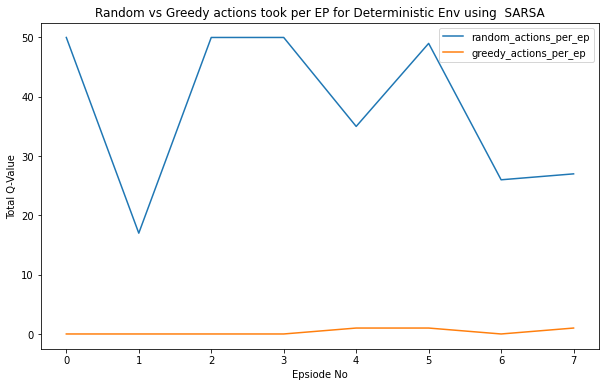

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 [-24.0, 92.0]
3 [-24.0]
4 [56.0]
5 [-59.0, 90.0]
6 []
7 [75.0]
8 []
9 []
10 [-67.0]
11 []
12 []
13 []
14 []
15 []


In [27]:
#run everything in default
main()

Q-Table
 [[  0   0   0   5]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0  22]
 [  0   0   0   0]
 [  0   0   0  17]
 [  0   0   2  15]
 [  2  41   0 -11]
 [  0  58   0   3]
 [  1  11   0  82]
 [ 11   3   0  78]
 [  0  47  -1  -3]
 [ -2  76   1   0]
 [ 31  94   5  34]
 [  0   0   0   0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2775499293.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


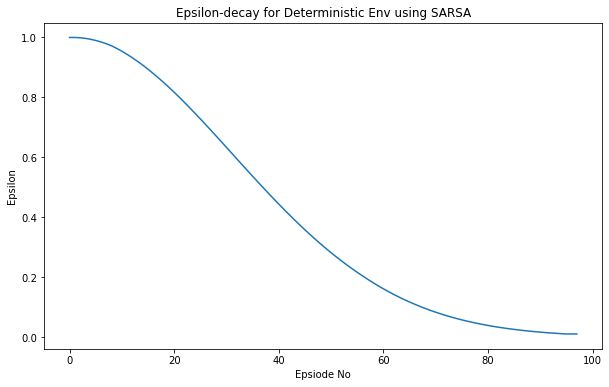

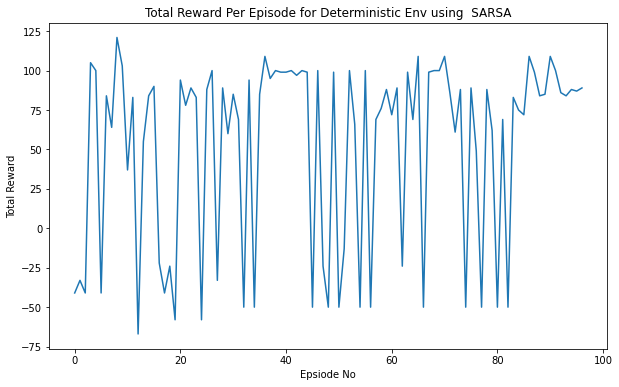

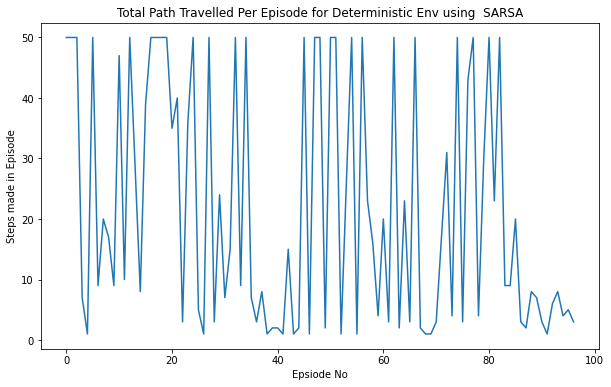

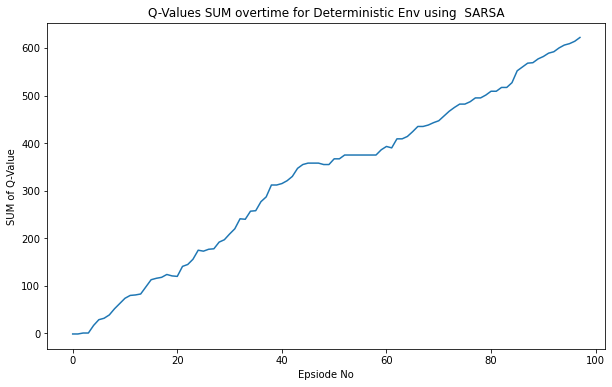

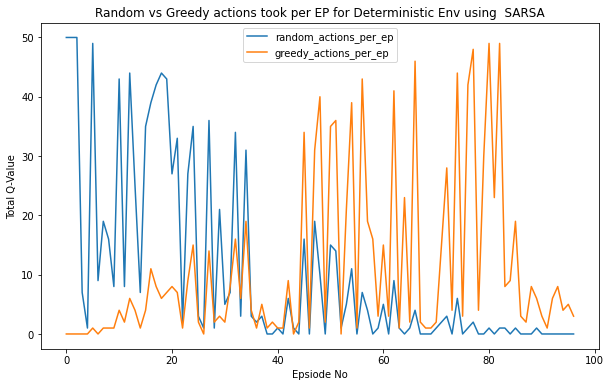

Starting-state,Total-Reward in an episode for all episodes 
0 [83.0, 55.0, 83.0, 69.0, -50.0, 49.0, -50.0, 69.0, 83.0, 72.0, 86.0]
1 [-33.0, 121.0, 94.0, -50.0, 97.0, -50.0, -50.0, -50.0, 76.0, -50.0, -50.0, 85.0]
2 [90.0, -24.0, 66.0, -50.0, 62.0, 84.0, 84.0]
3 [-41.0, 69.0, -50.0, -24.0, 61.0]
4 [105.0, 64.0, -58.0, 88.0, -50.0, -50.0, 69.0, 75.0, 87.0]
5 [72.0]
6 [-24.0, 89.0, 89.0]
7 [78.0, 99.0]
8 [84.0, 37.0, -67.0, -41.0, 88.0, 86.0, 88.0, 88.0, 88.0]
9 [-41.0, 103.0, 89.0, 89.0, 85.0, 89.0]
10 [99.0, 99.0, 99.0]
11 [85.0, 100.0, 100.0, 100.0, 100.0, 100.0]
12 [-41.0, -22.0, -58.0, 94.0, 109.0, 95.0, -13.0, 109.0, 109.0, 109.0, 109.0]
13 [84.0, -33.0, 99.0, 99.0, 99.0]
14 [100.0, 100.0, 60.0, 100.0, 100.0, 100.0, 100.0]
15 []


In [28]:
episodes = 100
main(episodes=episodes)

Q-Table
 [[  5   0   0  50]
 [ 36   0   0   0]
 [  0  84   0   0]
 [  0   0   4  64]
 [  0   0   0  60]
 [ 50   0   0   0]
 [  0   0  12  62]
 [  8   4   3  82]
 [  9  71   8 -10]
 [  0   9   1  82]
 [ 11  82   0  23]
 [  9  32  13  94]
 [ -2  82   0   0]
 [ -5  82   2   4]
 [  1  94   6  22]
 [  0   0   0   0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2775499293.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


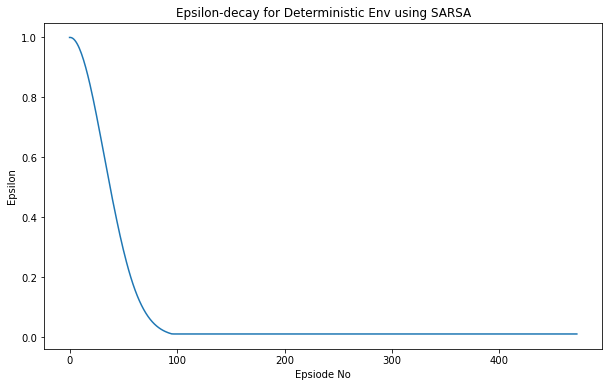

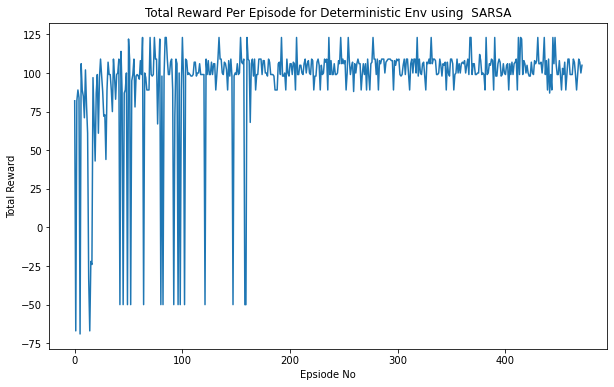

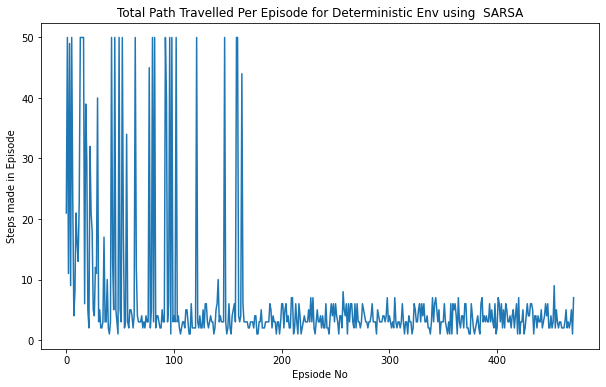

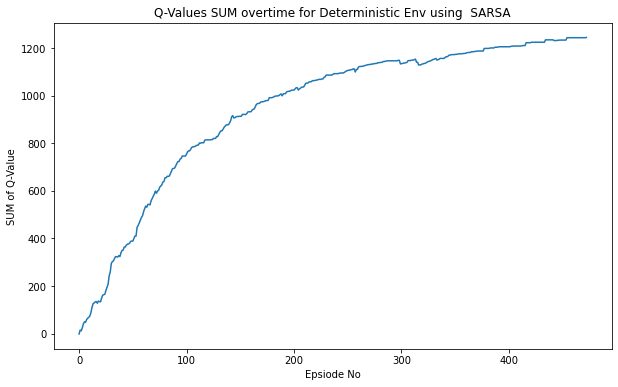

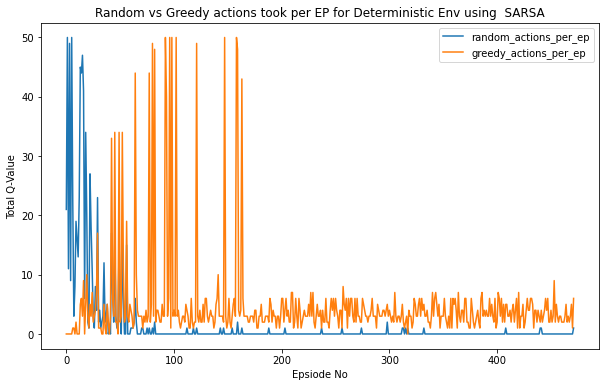

Starting-state,Total-Reward in an episode for all episodes 
0 [-50.0, 95.0, -50.0, -50.0, 72.0, -50.0, -50.0, -50.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0]
1 [-33.0, -50.0, 78.0, 67.0, -50.0, -50.0, -50.0, -50.0, -50.0, 68.0, 105.0, 105.0, 105.0, 105.0, 104.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 103.0, 105.0]
2 [102.0, 88.0, 123.0, 123.0, 123.0, 122.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 112.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0]
3 [-24.0, 97.0, 98.0, 114.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 87.0]
4 [-69.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107

In [29]:
episodes = 500 
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2775499293.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  5  6 50]
 [40  0  5 17]
 [31  0  0  0]
 [22  0  0  0]
 [ 0 60  6  9]
 [ 8  8  0 71]
 [60  0  0 -4]
 [ 0  0 17 82]
 [-1 71  8 -8]
 [26 18 10 82]
 [ 0 10  8 82]
 [ 0 16 11 94]
 [-1 82  0 -3]
 [-4 82 22 17]
 [20 94 19 59]
 [ 0  0  0  0]]


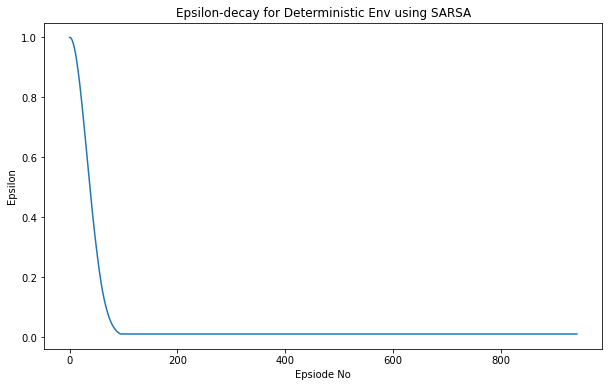

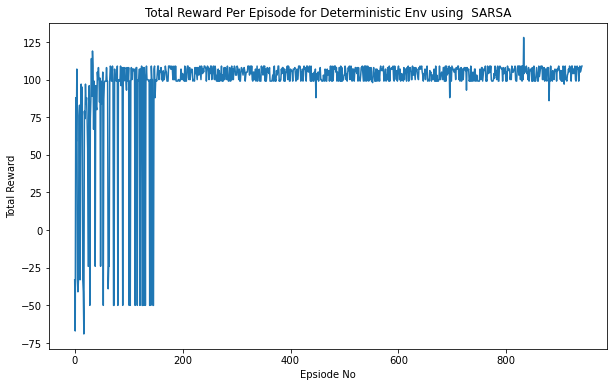

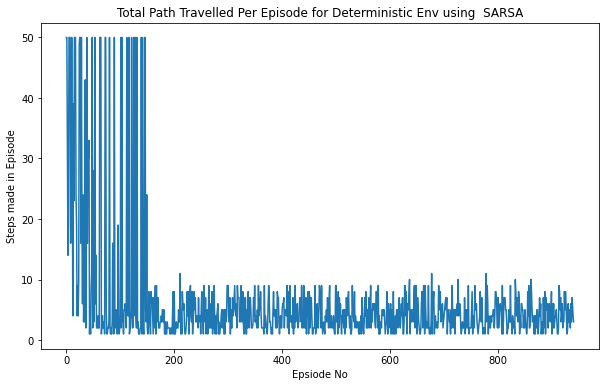

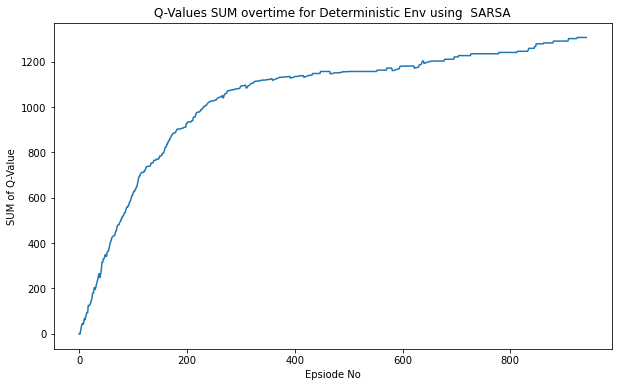

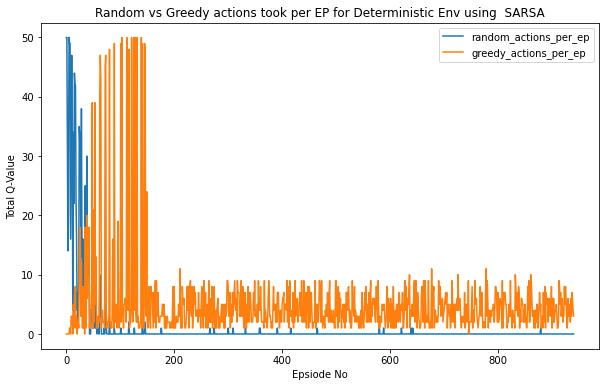

Starting-state,Total-Reward in an episode for all episodes 
0 [59.0, 95.0, -50.0, 74.0, 82.0, -39.0, -50.0, 93.0, -50.0, -50.0, -50.0, 106.0, 106.0, 106.0, 104.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 104.0, 106.0, 104.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 105.0, 104.0, 106.0, 86.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 104.0, 106.0, 106.0, 106.0, 106.0]
1 [-67.0, -24.0, 81.0, 101.0, 98.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 88.0, 105.0, 105.0, 105.0, 105.0, 105.0, 103.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0]
2 [-33.0, 71.0, 96.0, 119.0, 67.0, -50.0, -50.0

In [30]:
episodes = 1000
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/1636274157.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0 15]
 [ 0  3  0  0]
 [ 0 15  0  0]
 [ 1  0  0 13]
 [ 8  0  1 58]
 [50  2  0 20]
 [ 0 22  0 -3]
 [ 0  1  0 67]
 [37 67 15  3]
 [ 9 19  6 82]
 [ 0 75  0 11]
 [-1  0 14 94]
 [ 1 59  0  0]
 [10 82  0 23]
 [11 94 25 39]
 [ 0  0  0  0]]


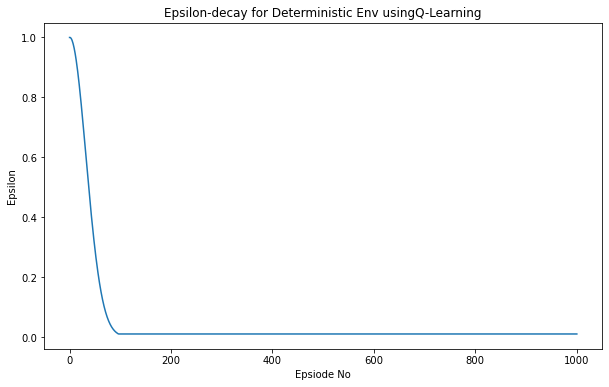

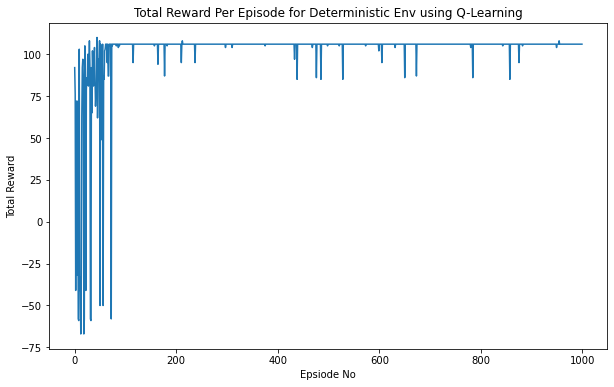

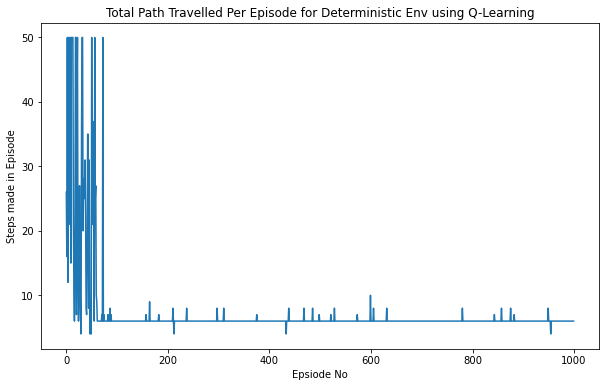

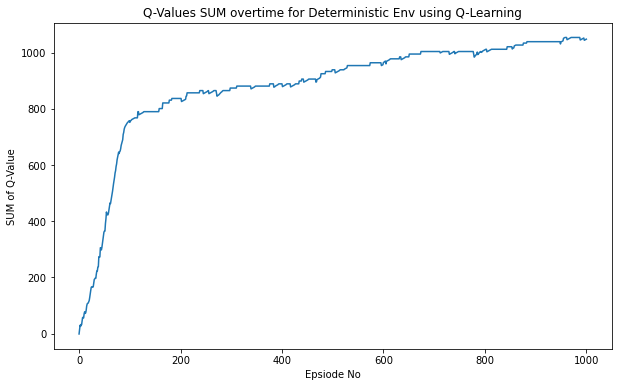

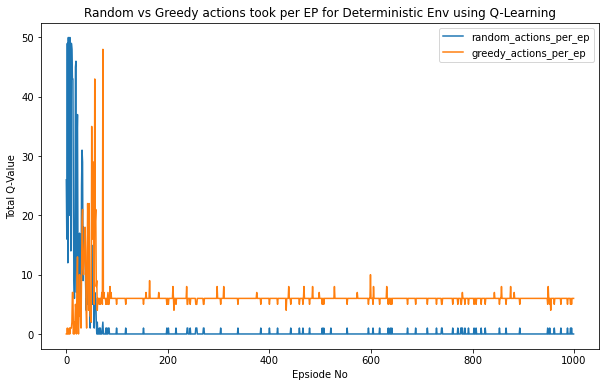

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 []
3 []
4 []
5 [92.0, 76.0, -41.0, 72.0, -32.0, 72.0, 71.0, -58.0, -59.0, 103.0, -41.0, -33.0, -67.0, -33.0, 63.0, 92.0, 97.0, 86.0, -67.0, -58.0, 105.0, 97.0, -41.0, 79.0, 86.0, 82.0, 100.0, 81.0, 94.0, 108.0, 93.0, -58.0, -59.0, 92.0, 65.0, 102.0, 90.0, 81.0, 96.0, 104.0, 85.0, 69.0, 77.0, 77.0, 110.0, 62.0, 83.0, 97.0, 95.0, 108.0, -50.0, 106.0, 90.0, 49.0, 91.0, 106.0, -50.0, 87.0, 85.0, 102.0, 103.0, 106.0, 106.0, 106.0, 95.0, 106.0, 87.0, 87.0, 106.0, 106.0, 105.0, 106.0, -58.0, 106.0, 105.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 105.0, 106.0, 106.0, 106.0, 104.0, 106.0, 105.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 95.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0, 106.0

In [10]:
episodes = 1000 
specific_start_state = 5
main(episodes=episodes,random_start_state=0,specific_start_state=specific_start_state)

## 2.stochastic env

In [11]:
class GridEnvironment_stochastic(GridEnvironment):
    
    def get_next_state(self,action):
        x = int(self.state / 4)
        y = int(self.state % 4 )

        if action == 0: #left            
            choice = random.choices([0,1],k=1, weights=(0.2,0.8))
            y -= choice[0]
        elif action == 1: #right
            choice = random.choices([0,1],k=1, weights=(0.1,0.9))   
            y += choice[0]
        elif action == 2: #up
            choice = random.choices([-1,1],k=1, weights=(0.3,0.7))  
            x -= choice[0]
        elif action == 3: #down
            choice = random.choices([-1,0,1],k=1, weights=(0.25,0.25,0.5))   
            x += choice[0]
        else:
            return -1
 
        x = np.clip(x,0,3)
        y = np.clip(y,0,3)
        next_state = 4*x + y
        
        return next_state

In [31]:
env_type = "Stochastic Env"
algo_type = " SARSA"
def main(episodes=10,gamma=0.95,random_start_state=1,specific_start_state=0):
    
    #set parameters
    alpha = 0.15 #learning-rate
    #gamma = 0.9 #discount_factor
    
    epsilon = 1 #greedy/random factor
    epsilon_decay_rate = 0.001 #greedy/random factor decay rate

    #set tracking variables
    epsilon_vals = np.array([epsilon]) #do eps-decay
    total_path_travelled = np.array([]) #for no of tranisitions-made
    total_reward_per_ep = np.array([]) #for total rewards collected in an episode
    q_values_sum = np.array(-1) #to check the convergence of q-values
    random_actions_per_ep = np.array([]) #for no of random actions took per episode
    greedy_actions_per_ep = np.array([]) #for no of greedy actions took per episode
    total_actions_per_ep = np.array([]) #for no of overall actions took per episode(transitions made)
    state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)
    for i in range(state_rewards.shape[0]): #initialize the above variable
        state_rewards[i] = np.array([])
    
    #set environment and agent
    env = GridEnvironment_stochastic()
    env.reset()
    agent = RandomAgent(env,epsilon,epsilon_decay_rate)
    agent.reset()
    
    #start training
    for ep in range(episodes):
        #now = time.time()
        #print("Episode No:",ep,"time taken till this ep:",np.round(now-program_starts,2),"s")
        
        env.reset() #reset env beore each episode
        agent.reset() #reset agent before each episode
        
        #check if we need a random start state or a specified start state for each epiode
        if random_start_state:
            #choose a random start state
            S = env.observation_space.sample()
            if S == env.terminal_state: # if inital state is final state, terminate the episode
                ep -= 1
                continue
        else:
            S = specific_start_state
        env.state = S #set env state to the chosen state
        
        #trackers for episodic data
        start_state = S #start state of the episode
        episode_path = np.array([]) #path of the episode
        episode_rewards = 0 #rewards collected in the episode
        greedy_count = 0 #greedy actions took in the episode
        random_count = 0 #random actions took in the episode
        total_count = 0 #all actions took in the episode(transitions)
                                         
        #till it's not a terminal state
        while S != env.terminal_state:  
            
            A = agent.step(S) #agent chooses an action
            NS , R, Done, Info = env.step(A) #env gives feedback for the action chosen through 
                                                                            #next available state,
                                                                            #reward recieved etc
            NA = agent.step(NS) #agent chooses next action based on next state
            agent.update_q_table(S,A,R,NS,NA,alpha,gamma) #agent updates it's Q-table(policy)
            
            episode_path = np.append(episode_path,S) #add to episode path
            episode_rewards += R #increase episode rewards
            
            #print(S,A,R,NS,episode_rewards)
            
            S = NS #change state to next state
            env.state = S #change environment's state
            
            #increase action counts accordingly
            if agent.action_type == 0: #random
                random_count += 1 
            if agent.action_type == 1: #greedy
                greedy_count += 1
            total_count += 1
            
            #if timesteps are maxed, terminate the episode
            if Done:
                break
                
            #env.render()
        
        #decay epsilon
        agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**ep) #exponential decay
        agent.epsilon = max(agent.epsilon,0.01) #keep epsilon to a min value so that 
                                                #agent can explore even in latter stages
        
        #update all tracking-variables
        epsilon_vals = np.append(epsilon_vals,agent.epsilon) #
        total_reward_per_ep = np.append(total_reward_per_ep,episode_rewards)
        total_path_travelled = np.append(total_path_travelled,len(episode_path))
        q_values_sum = np.append(q_values_sum,agent.q_table.sum())
        random_actions_per_ep = np.append(random_actions_per_ep,random_count)
        greedy_actions_per_ep = np.append(greedy_actions_per_ep,greedy_count)
        total_actions_per_ep = np.append(total_actions_per_ep,total_count)
        state_rewards[start_state] = np.append(state_rewards[start_state],episode_rewards)
    
    #env.render() 
    print("Q-Table\n",agent.q_table)
    #print(get_all_states_max_reward_path(agent.q_table))
    plot_eps_decay(epsilon_vals,env_type,algo_type) #plot epsiolon values over time
    plot_cum_rewards(total_reward_per_ep,env_type,algo_type) #plot total rewards for each episode
    plot_paths_travelled(total_path_travelled,env_type,algo_type) #plot total transitions for each episode
    plot_q_values_sum(q_values_sum,env_type,algo_type) #plot avg q-values for each episode
    #plot actions type for each episode
    plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type) 
    #print(total_actions_per_ep)
    print("Starting-state,Total-Reward in an episode for all episodes ")
    for i in range(state_rewards.shape[0]): # for each state as an inital state
        print(i,list(state_rewards[i])) #print it's total episodic rewards
        

Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  6  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  8  0]
 [ 0  0 -3 -2]
 [ 0 -1  0  3]
 [ 0  0  0  1]
 [ 0  0  0 26]
 [ 0  0  0  0]
 [ 0  2  0  0]
 [ 1 27 -1 -1]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2730259699.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


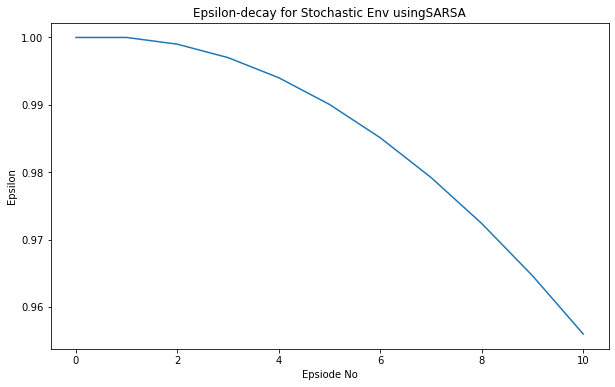

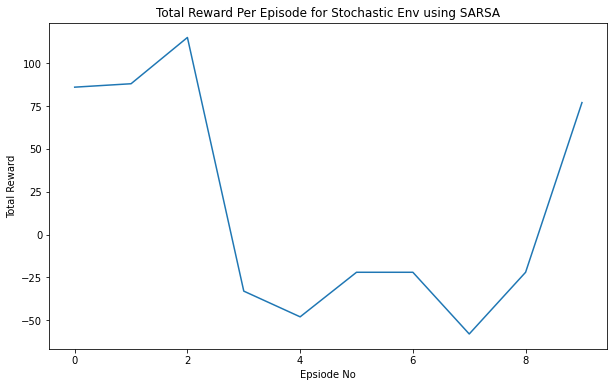

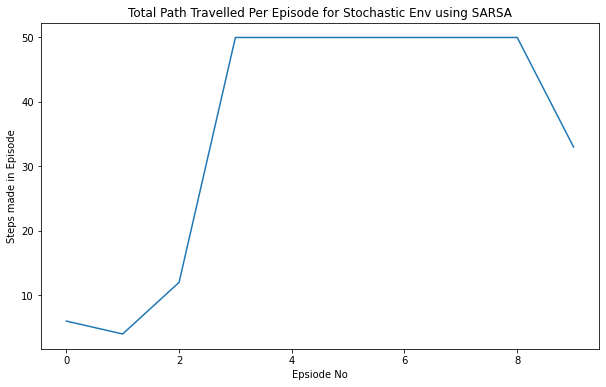

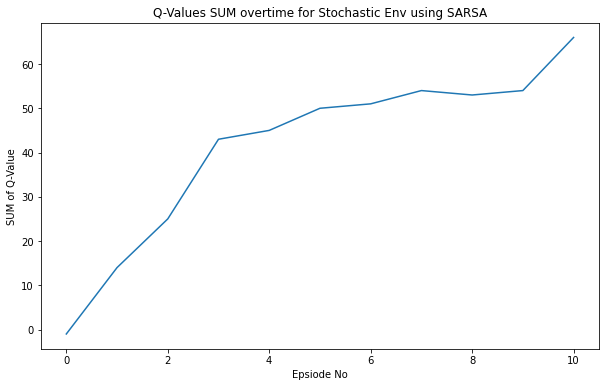

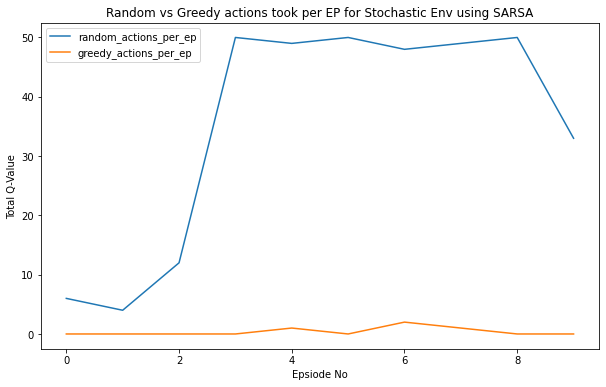

Starting-state,Total-Reward in an episode for all episodes 
0 [115.0]
1 [-48.0]
2 [77.0]
3 []
4 []
5 [-33.0, -58.0]
6 []
7 [-22.0]
8 []
9 [88.0, -22.0, -22.0]
10 []
11 []
12 []
13 [86.0]
14 []
15 []


In [16]:
#run everything in default
main()

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2730259699.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  1 19  8]
 [-1  6 -2 -5]
 [ 0  0  3 32]
 [ 2 15  0  7]
 [ 0  8 12 51]
 [ 0 20  0 -1]
 [-2 74  4  2]
 [ 2 94  0 15]
 [ 0  0  0  0]]


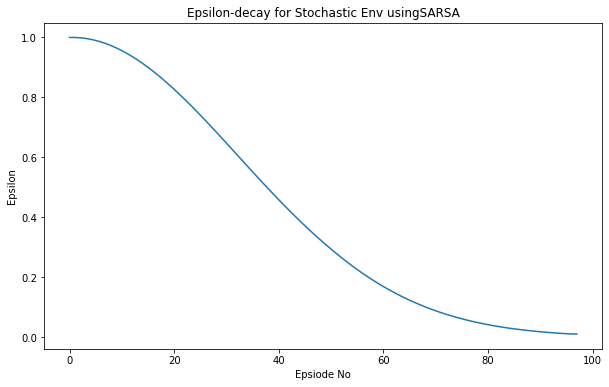

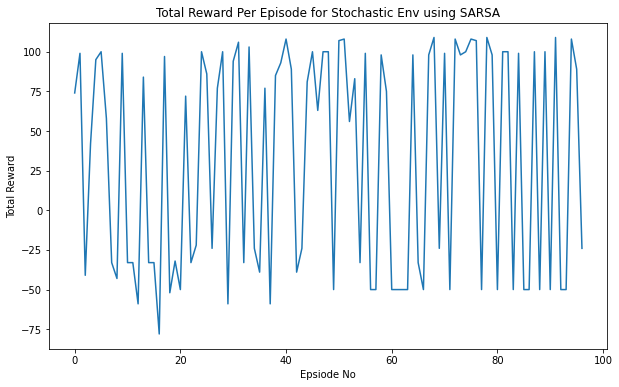

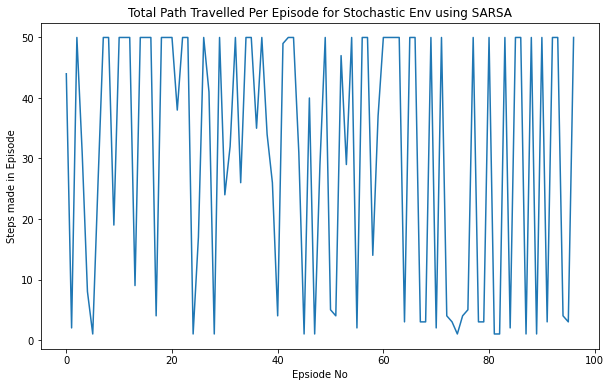

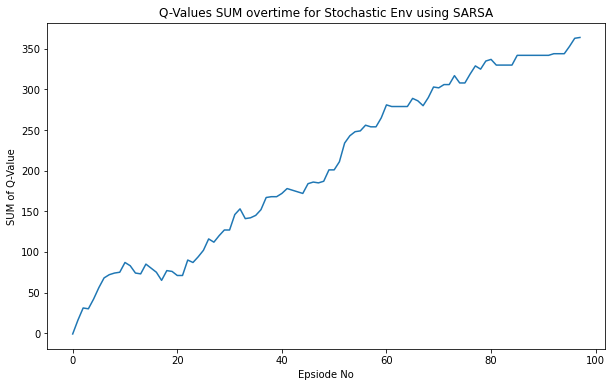

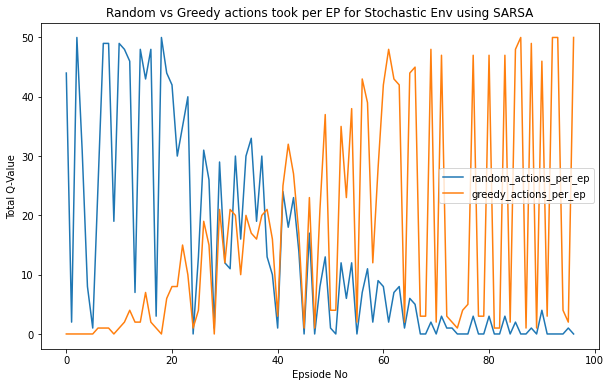

Starting-state,Total-Reward in an episode for all episodes 
0 [-33.0, -59.0, -24.0, -24.0, 77.0, -59.0, -39.0, 75.0, -50.0, -50.0]
1 [-33.0, 81.0, 63.0, -50.0, -50.0, -50.0]
2 [74.0, -33.0, -39.0, -50.0, -50.0]
3 [-52.0, -50.0, -22.0, -24.0, -50.0]
4 [-43.0, -50.0, -50.0]
5 [-33.0, -59.0, -33.0, 98.0, -50.0, -50.0, -50.0, -50.0, -50.0]
6 [99.0, 93.0, 89.0, 56.0, -50.0, -50.0]
7 [-33.0, 97.0, -33.0, 98.0, -24.0, -24.0]
8 [-41.0, 86.0, 108.0, 107.0]
9 [-78.0, 77.0, 108.0, 107.0, 108.0, 109.0, 108.0]
10 [42.0, -33.0, -32.0, 106.0, 85.0, 83.0, -33.0, -50.0, 99.0, 89.0]
11 [99.0, 94.0, 103.0, 100.0, 98.0]
12 [58.0, 72.0, 109.0, 108.0]
13 [84.0, 99.0, 99.0, 98.0, 98.0, 109.0]
14 [95.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
15 []


In [17]:
episodes = 100
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2730259699.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  1  0 26]
 [12  0  0  0]
 [ 7  0  0  0]
 [ 1  0  0  0]
 [ 5  0  0 42]
 [30  0  0  0]
 [18  0 -1 -4]
 [ 0  0 45  4]
 [-1 55  1  2]
 [13 10  0 63]
 [ 0 66  0  0]
 [ 0  0 31 77]
 [ 0 82 -1  0]
 [17 82 11  0]
 [ 0 94 12 -1]
 [ 0  0  0  0]]


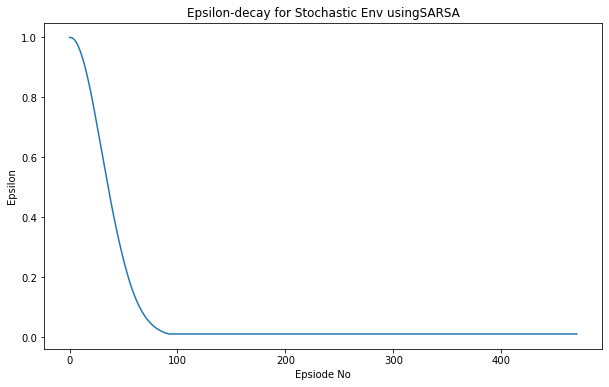

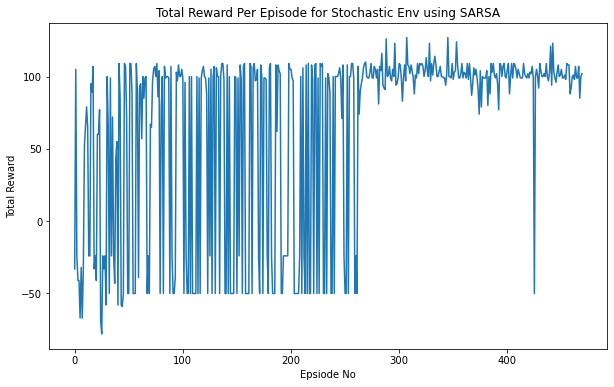

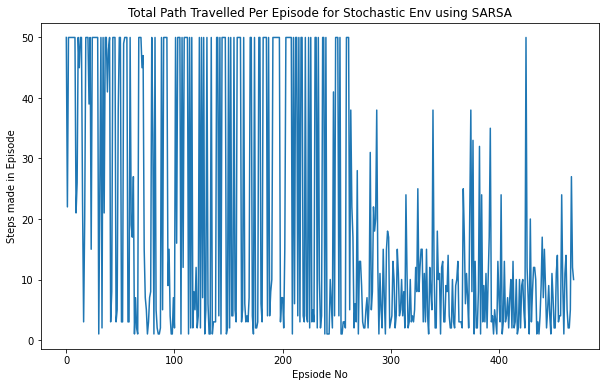

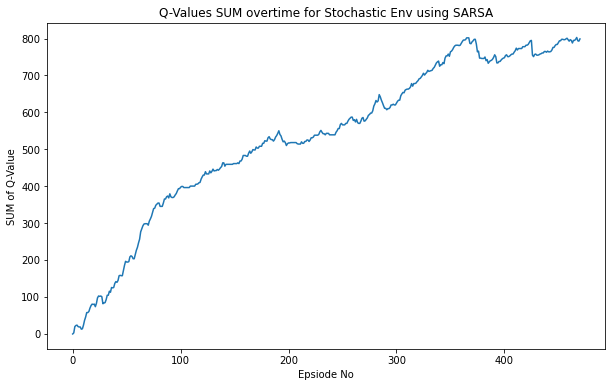

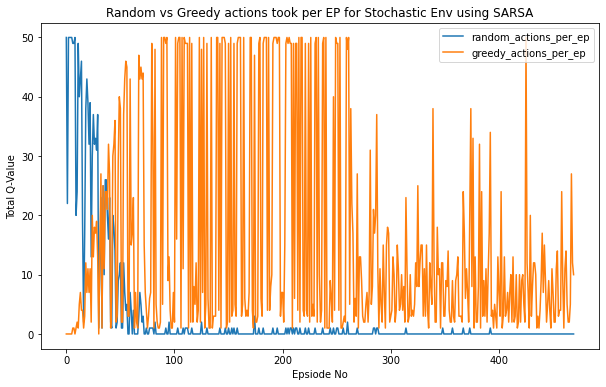

Starting-state,Total-Reward in an episode for all episodes 
0 [52.0, 66.0, -39.0, -50.0, -50.0, -50.0, -50.0, 100.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 105.0, 97.0, 104.0, 106.0, 105.0]
1 [79.0, -24.0, -24.0, 60.0, 77.0, -69.0, -50.0, -58.0, -50.0, 65.0, -50.0, -50.0, -50.0, -50.0, 104.0, -50.0, -50.0, -50.0, -50.0, -50.0, 99.0, 103.0, 105.0, 103.0, 103.0, 99.0, 104.0, 77.0, 99.0, 105.0, 88.0]
2 [-33.0, -33.0, -33.0, -24.0, -50.0, -50.0, -50.0, -24.0, -39.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 90.0, 100.0, 94.0, 104.0, 102.0, 101.0, 102.0, 85.0]
3 [-24.0, -50.0, -50.0, -50.0, -24.0, -24.0, -50.0, -50.0, -50.0, -24.0, 101.0, 123.0, 100.0, 100.0, 100.0, 100.0, 87.0, 74.0, 102.0, 88.0, 99.0, 92.0, 101.0, 102.0]
4 [-24.0, 95.0, 107.0, 72.0, -58.0, 93.0, 105.0, 107.0, 78.0, 107.0, 100.0, -50.0, -50.0, -50.0, -50.0, 105.0, -50.0, 106.0, 107.0, -50.0, 102.0, -50.0, 106.0, -50.

In [18]:
episodes = 500 
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2730259699.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 4  3  8 23]
 [14  0  3  1]
 [ 7  0  0  2]
 [ 6  0  0  0]
 [ 0  5  0 42]
 [30  1  7 15]
 [19  0 -1  0]
 [ 0  3  3 54]
 [ 6 64  2  4]
 [13  5 14 70]
 [ 2 68  2  3]
 [12 26 10 79]
 [ 0 82  0  0]
 [ 7 74 22 17]
 [14 94  4 22]
 [ 0  0  0  0]]


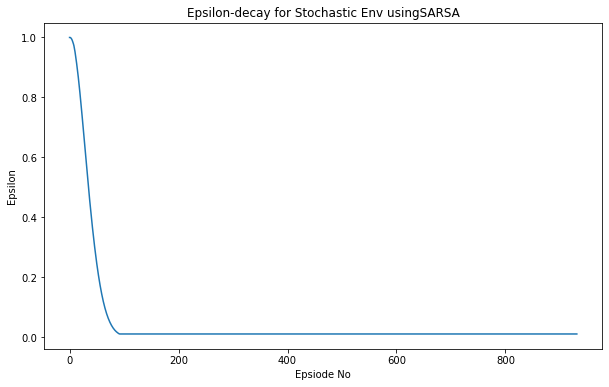

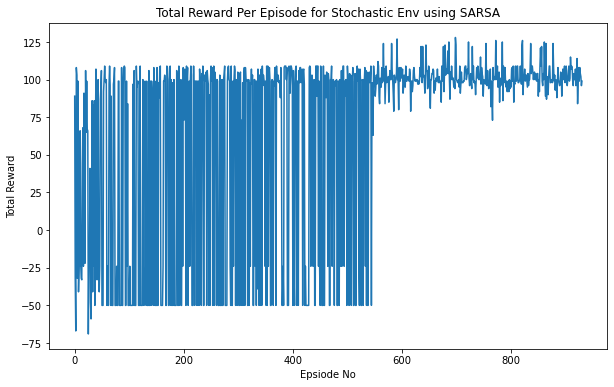

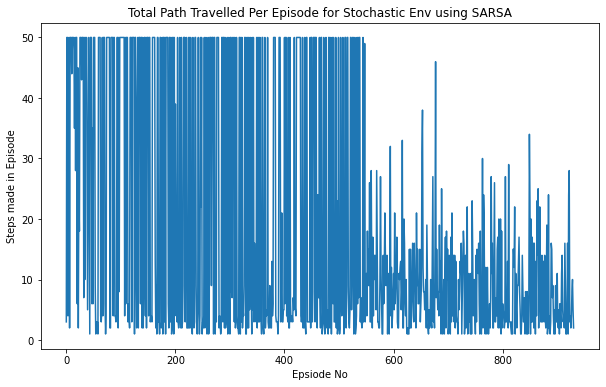

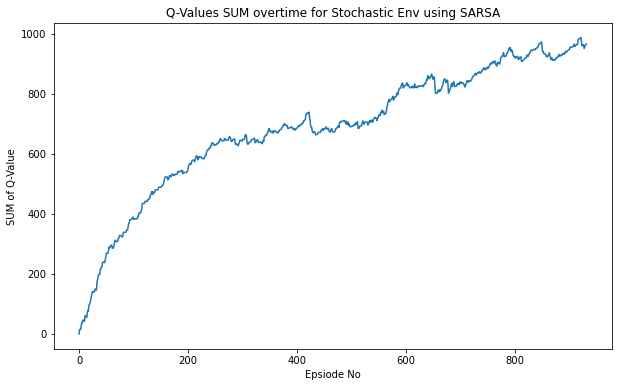

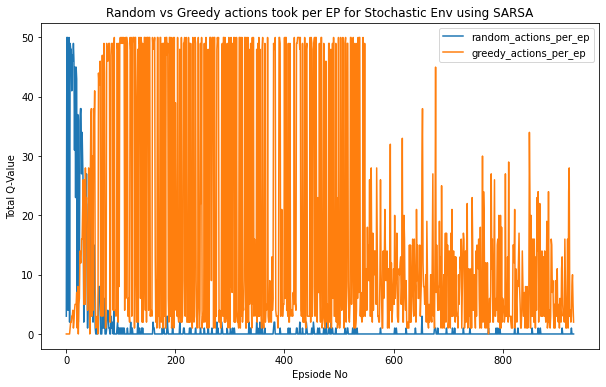

Starting-state,Total-Reward in an episode for all episodes 
0 [-50.0, 92.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 63.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -39.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 102.0, 102.0, 100.0, 102.0, 105.0, 104.0, 90.0, 101.0, 95.0, 92.0, 97.0, 90.0, 104.0, 104.0, 96.0, 89.0, 98.0, 105.0, 84.0]
1 [88.0, 94.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 96.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 79.0, 103.0, 80.0, 102.0, 105.0, 102.0, 101.0, 98.0, 105.0, 104.0, 95.0, 102.0, 101.0, 98.0, 82.0, 86.0, 105.0, 101.0, 99.0, 95.0, 104.0, 105.0, 102.0, 102.0, 93.0, 88.0, 104.0]
2 [66.0, -24.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0

In [19]:
episodes = 1000
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2366/2730259699.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0 22]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 5  2 12 36]
 [30  0  0  6]
 [ 7  0  0  0]
 [ 0  0  4 18]
 [10 51 -1  0]
 [21  1 13 56]
 [ 0 22  4  1]
 [ 0  4 20 38]
 [ 0 45  0  0]
 [ 4 82  0 37]
 [15 94 17 31]
 [ 0  0  0  0]]


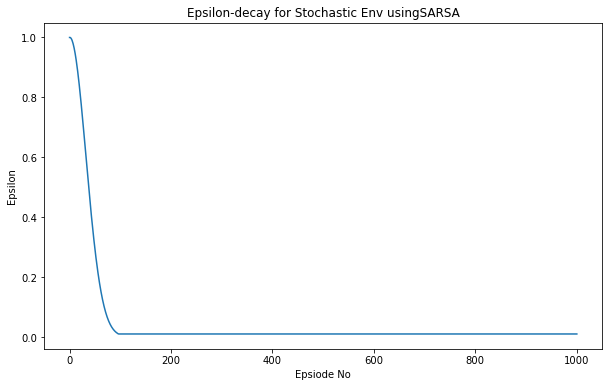

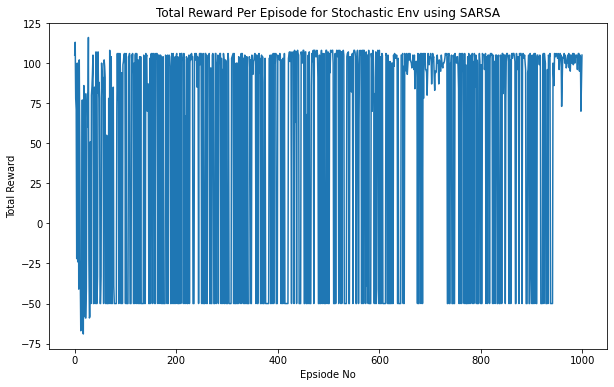

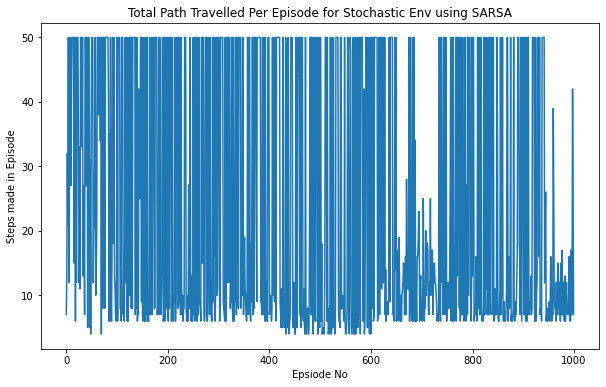

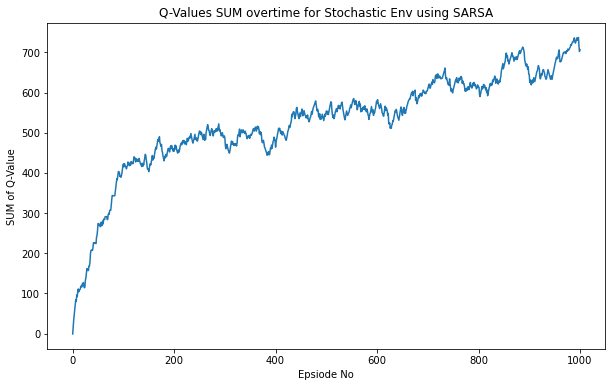

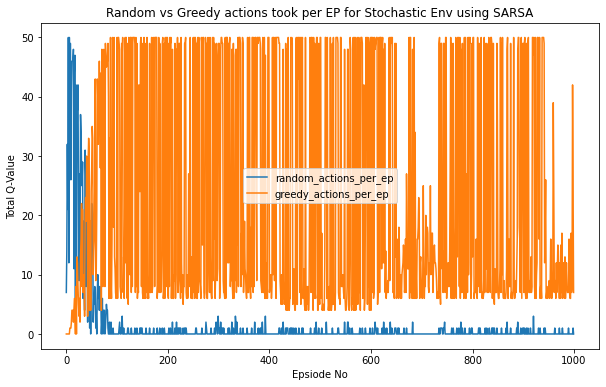

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 []
3 []
4 []
5 [105.0, 113.0, 78.0, 71.0, -22.0, 100.0, -24.0, 99.0, -41.0, 102.0, 49.0, -33.0, -67.0, -32.0, -22.0, 77.0, -67.0, -69.0, 86.0, -58.0, 81.0, -59.0, -59.0, -41.0, 75.0, 81.0, 60.0, 116.0, -22.0, -59.0, -58.0, 51.0, -50.0, 80.0, 85.0, 93.0, 105.0, -50.0, -50.0, 85.0, 65.0, -50.0, 107.0, -50.0, -50.0, -33.0, 107.0, 81.0, 88.0, 78.0, -50.0, -50.0, -33.0, 100.0, 92.0, 91.0, 80.0, -50.0, 102.0, 98.0, 91.0, -50.0, -50.0, 55.0, -50.0, -50.0, -50.0, 78.0, -50.0, 108.0, -41.0, -50.0, 104.0, -50.0, -50.0, 66.0, 85.0, -39.0, -50.0, -50.0, -50.0, -50.0, -50.0, 72.0, 106.0, 77.0, 106.0, -50.0, 82.0, 106.0, 96.0, -50.0, -50.0, 94.0, -50.0, 99.0, 101.0, 105.0, 106.0, 99.0, -50.0, 106.0, -50.0, -50.0, -50.0, -50.0, 104.0, 104.0, 106.0, -50.0, -50.0, -50.0, 105.0, 98.0, 106.0, 93.0, -50.0, 100.0, -50.0, 105.0, 106.0, -50.0, 106.0, -50.0, 100.0, 102.0, -50.0, -50.0, 104.0, -50.0, 104.0, -50.0, -50.0, -50.0, -50.0, -50.

In [20]:
episodes = 1000 
specific_start_state = 5
main(episodes=episodes,random_start_state=0,specific_start_state=specific_start_state)